In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import bambi as bmb

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.3


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Probabilistic Reformulation of Linear Models

Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be reformulated as:

                                Y ~ N(X*beta, sigma^2)

In words, we view 
 as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance 
.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

Priors: We can quantify any prior knowledge we might have by placing priors on the parameters. For example, if we think that 
 is likely to be small we would choose a prior with more probability mass on low values.

Quantifying uncertainty: We do not get a single estimate of 
 as above but instead a complete posterior distribution about how likely different values of 
 are. For example, with few data points our uncertainty in 
 will be very high and we’d be getting very wide posteriors.

# Bayesian GLM in PyMC

### Generating Data

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

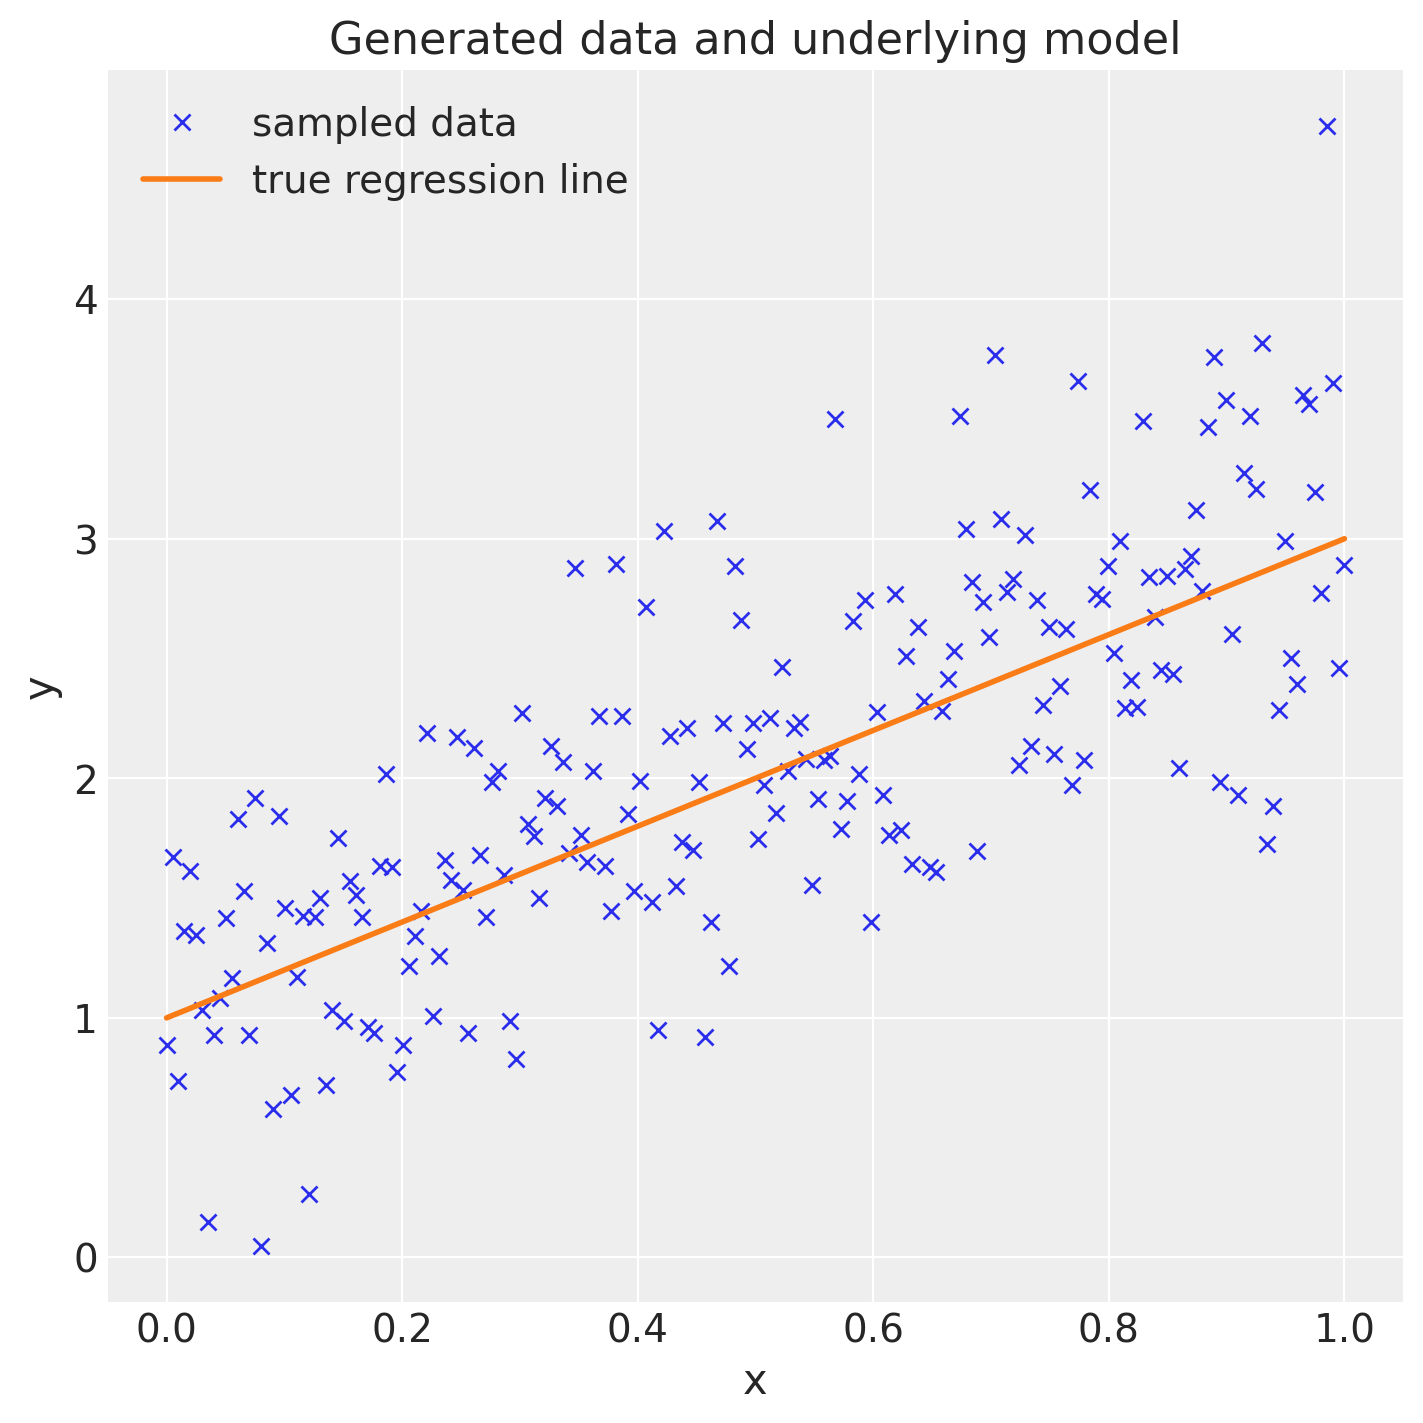

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

### Estimating the model

In [5]:
with pm.Model() as model:
    # define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)
    
    # define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)
    
    # inference
    idata = pm.sample(3000)

/tmp/ipykernel_19903/2427721923.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = HalfCauchy("sigma", beta=10, testval=1.0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.


Even simple way to deal with this is use Bambi package

In [10]:
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


#### Analyzing the model

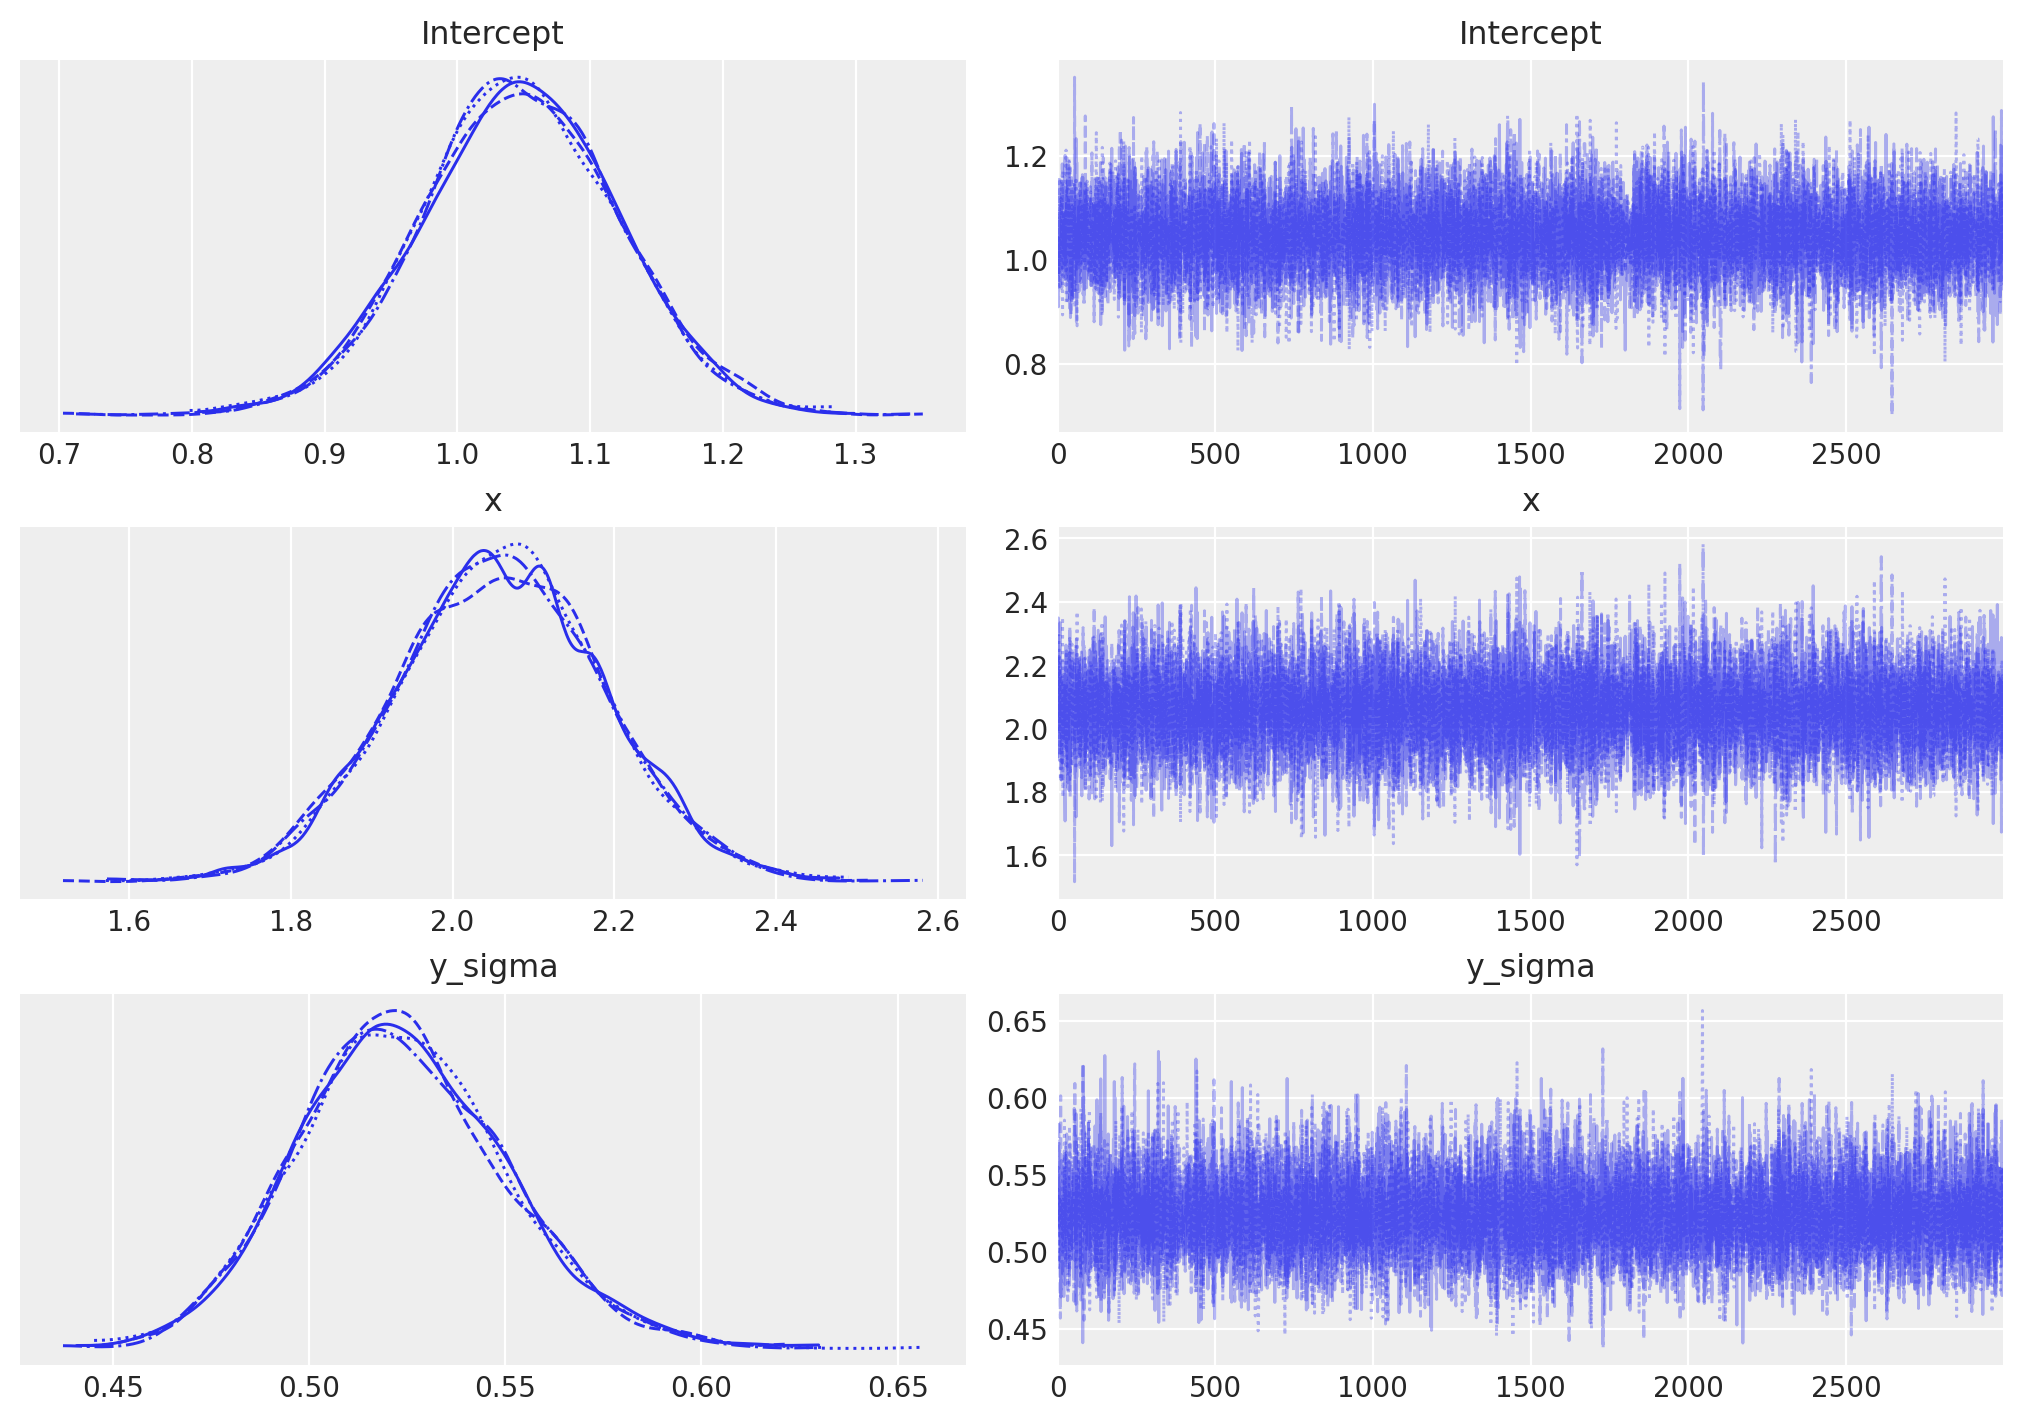

In [11]:
az.plot_trace(idata, figsize=(10, 7));

In GLMs, we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

In [17]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

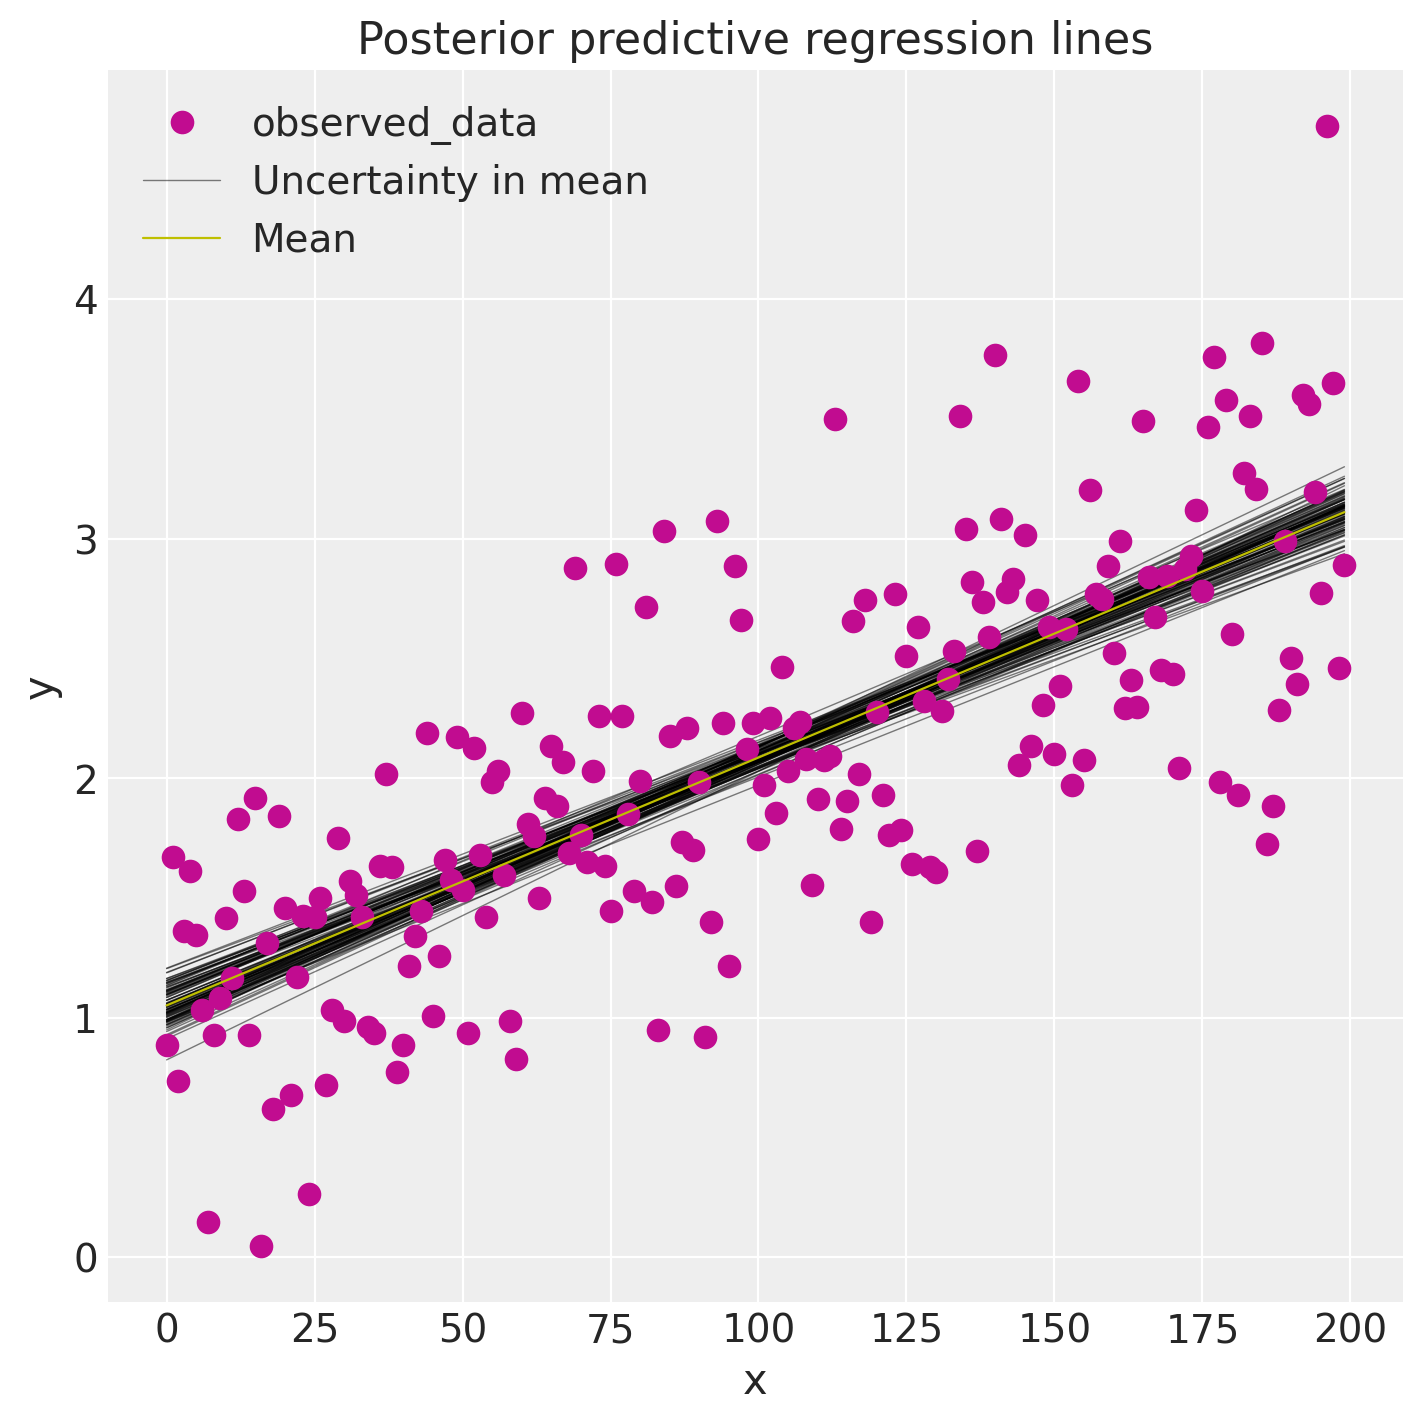

In [20]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");